# Análise e Transformação de Dados
#### Licenciatura em Engenharia Informática - Universidade de Coimbra
#### 2020/2021

## Projeto final

### Autores:
- João Filipe Guiomar Artur, 2019217853
- Samuel Santos Carinhas, 2019217199
- Sancho Amaral Simões, 2019217590

## 1. Introdução

<div style="text-align: justify">&nbsp;&nbsp;&nbsp;&nbsp;O presente projeto tem como finalidade a aplicação de alguns dos conhecimentos adquiridos pelos autores no âmbito da cadeira de <strong>Análise e Transformação de Dados</strong>, nomeadamente a análise de dados originalmente facultados no domínio temporal e a sua posterior transposição para o domínio da frequência / domínio misto (frequência/tempo), com recurso a ferramentas matemáticas como a transformada de Fourier e as suas variantes (DFT, STFT, ...). 
<br>&nbsp;&nbsp;&nbsp;&nbsp;Para o desenvolvimento deste projeto, foi fornecido um dataset no qual constam valores recolhidos por acelerómetros de smartphones nas três dimensões (x, y e z). Estes valores são provenientes de várias sequências de movimentos executados por um grupo de 30 voluntários. Nas referidas sequências encontram-se movimentos de tipo estático, dinâmico e de transição. A terminologia utilizada para caracterizar os grupos de movimentos é bastante autoxplicativa, como se vê em baixo. 
    
<ul>
     <li> 
         <h5> Dinâmicos </h5>
         <ol>
             <li> Andando (WALKING) </li>
             <li> Subindo Escadas (WALKING_UPSTAIRS) </li>
             <li> Descendo Escadas (WALKING_DOWNSTAIRS) </li>
         </ol>
     </li>
     <li> 
         <h5> Estáticos </h5>
         <ol>
             <li> Sentado (SITTING) </li>
             <li> De pé (STANDING) </li>
             <li> Deitado (LAYING) </li>
         </ol>
     </li>
    <li> 
         <h5> Transição </h5>
         <ol>
             <li> De pé -> Sentado (STAND_TO_SIT) </li>
             <li> Sentado -> De pé (SIT_TO_STAND) </li>
             <li> Sentado -> Deitado (SIT_TO_LIE) </li>
             <li> Deitado -> Sentado (LIE_TO_SIT) </li>
             <li> De pé -> Deitado (STAND_TO_LIE) </li>
             <li> Deitado -> De pé (LIE_TO_STAND) </li>
         </ol>
     </li>  
</ul>
    
&nbsp;&nbsp;&nbsp;&nbsp;
</div>

## 2. Workspace

&nbsp;&nbsp;&nbsp;&nbsp;Para maior legibilidade / facilidade de manutenção de código, foi criado um workspace inicial que contém algumas constantes utilizadas ao longo do desenvolvimento do projeto.

In [132]:
% region dependencies
addpath('functions/dft/');
addpath('functions/util/');
addpath('functions/plotters/');
% endregion dependencies

% region constants
X_AXIS = 1;
Y_AXIS = 2;
Z_AXIS = 3;
DATASETS_DIR = 'resources/txt/datasets';
LABELS_PATH = 'resources/txt/labels.txt';
COLORS = {'#2f4f4f', '#7f0000', '#008000', '#00008b', '#ff8c00', '#CC3322', '#11ff00', '#00ffff', '#ff00ff', '#1e90ff', '#ffe4b5', '#fd4002'};
ACTIVITIES = ["WALK", "WALK\_UP", "WALK\_DOWN", "SIT", "STAND", "LAY", "STAND\_SIT", "SIT\_STAND", "SIT\_LIE", "LIE\_SIT", "STAND\_LIE", "LIE\_STAND"];
ABS_SLOPE_PARAM = 'Absolute slope';
MAX_FREQ = 'Max frequency amplitude';
FS = 50;
THRESHOLD1 = 0.25;
THRESHOLD2 = 0.3;
WINDOW_SIZE = 8;
OVERLAP_SIZE = 6;
ACT_SIZES = [2000, 2500, 1500];
DYNAMIC_ACTIVITIES = [1, 2, 3];
LOW_PASS_MIN_FREQ = 0.2;
% end region constants

## 3. Importação de dados

&nbsp;&nbsp;&nbsp;&nbsp;Os datasets fornecidos foram importados através da utilização da função load_datasets. Esta percorre todos os ficheiros .txt no diretório especificado e lê, através da função dlmread, os valores lidos pelos acelerómetros, utilizando como delimitador o espaço.

In [133]:
%%file load_datasets.m

function datasets = load_datasets(directory)
    dataset_files = dir([directory '/*.txt']);
    len = length(dataset_files);
    datasets = cell(1, len);
    
    for i = 1:len
        datasets(i) = {dlmread([directory '/' dataset_files(i).name], ' ')};
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\load_datasets.m'.


In [134]:
labels = dlmread(LABELS_PATH, ' ');
datasets = load_datasets(DATASETS_DIR);

## 4. Representação dos sinais

&nbsp;&nbsp;&nbsp;&nbsp;Os datasets fornecidos foram representados graficamente com recurso à função plot_datasets. Esta percorre os dados ao mesmo tempo que percorre a variável labels para assim ser possível distinguir as diferentes atividades no sinal correspondente á experiência em questão. A representação gráfica dos sinais apresenta os valores medidos pelos acelerómetros, em $ m/s^2 $, em função do tempo, em $ minutos $. Para distinção das várias atividades foi selecionado um conjunto de cores de modo a maximizar o contraste entre as mesmas.

In [152]:
%%file plot_datasets.m

%{
@def plot_datasets
@brief Function that plots the dataset describing the experiences.

@param datasets
Datasets to containing the values obtained in the experiences.

@param fs
Sample frequency used when capturing the values on the dataset.

@param labels
Vector with labels describing the experiences performed by the users.

@param activities
Vector with names atributed to each activity.

@param act_colors
Vector with color RGB codes to assign to mark each activity.
%}
function plot_datasets(datasets, fs, labels, activities, act_colors)
    len = length(datasets);
    ts = 1/fs;
   
    % consider all of the activities present in the datasets
    for i = 1:len
        figure;
        dataset = cell2mat(datasets(i));

        indexes = find(labels(:,1) == i);
       
        exp = i;
        
        % consider each of the three dimensions for each activity
        for k = 1:3
            y_lbl = sprintf('ACC - %s (m/s^2)', get_axis_name(k));
            
            subplot(3, 1, k);
            plot(ts/60:ts/60:(length(dataset) * ts)/60, dataset(:, k), 'k');
            ylabel(y_lbl);
            xlabel('Time (min)')
           
            hold on

            for j=1:length(indexes)
                index = indexes(j);
                user = labels(index, 2);
                act = labels(index, 3);
                start = labels(index, 4);
                finish = labels(index, 5);
                
                x = start * ts/60:ts/60:finish * ts/60;
                y_point = mean(dataset(start:finish, k)) + 0.7 * (-1)^index;
                color_hex = char(act_colors(act));
                color = sscanf(color_hex(2:end),'%2x%2x%2x',[1 3])/255;
                
                plot(x, dataset(start:finish, k), 'Color', color);
                text(start*ts/60, y_point, activities(act),'Fontsize', 7);
                plt_title = sprintf('Experience %d, User %d', exp, user);
                sgtitle(plt_title);
            end

            hold off;
        end
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_datasets.m'.


In [ ]:
plot_datasets(datasets, FS, labels, ACTIVITIES, COLORS);

![Title](resources/plots/datasets/dataset1.png)
![Title](resources/plots/datasets/dataset2.png)
![Title](resources/plots/datasets/dataset3.png)
![Title](resources/plots/datasets/dataset4.png)
![Title](resources/plots/datasets/dataset5.png)
![Title](resources/plots/datasets/dataset6.png)
![Title](resources/plots/datasets/dataset7.png)
![Title](resources/plots/datasets/dataset8.png)


## 5. Preparação dos datasets

<div style="text-align: justify">
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Para normalizar/uniformizar e refinar os dados fornecidos foi criada a função <strong>prepare_datasets</strong>. Esta retorna o número de instâncias ocorridas de cada atividade em todas as experiências, a média dos segmentos associados a cada atividade, as suas $ DFTs $ (c/ média aplicada) e o respetivo vetor de frequências e algumas outras variáveis que são utilizadas no último ponto deste projeto (reconhecimento das atividades com base no conhecimento adquirido à priori). Convém salientar que, apesar de as várias experiências terem sido realizadas por sujeitos fisicamente diferentes, as variações dos valores medidos pelos acelerómetros não são significativas. A aplicação da média nas várias atividades e nas suas $ DFTs $, além de facilitar o tratamento dos dados, aproveita este facto na medida em que atenua ainda mais possíveis variações existentes, aumentando assim a exatidão dos valores medidos.
</div>

In [159]:
%%file prepare_datasets.m


function [num_act_ocurrences, acts_means, dft_freqs, dft_means, solver_slopes, solver_freqs, solver_mags] = prepare_datasets(datasets, dim, fs, unif_sizes, labels, activities)
   num_act = length(activities);
   dft_means = cell(1, num_act);
   dft_freqs = cell(1, num_act);
   acts_means = cell(1, num_act);
   solver_slopes = cell(1, num_act);
   solver_freqs = cell(1, num_act);
   solver_mags = cell(1, num_act);
   num_act_ocurrences = zeros(1, num_act);
   min_act_size = zeros(1, num_act);
   dyn_act_size = unif_sizes(1);
   static_act_size = unif_sizes(2);
   transition_act_size = unif_sizes(3);
    
   len = length(datasets);
   
   for i = 1:len
       dataset = cell2mat(datasets(i));
       
       indexes = find(labels(:, 1) == i);
           
       for j=1:length(indexes)
           index = indexes(j);
           act = labels(index, 3);
           start = labels(index, 4);
           finish = labels(index, 5);

           act_frag = dataset(start:finish, dim);
           
           slope = get_abs_slope(start:finish, act_frag);

           num_act_ocurrences(act) = num_act_ocurrences(act) + 1;
           l = size(act_frag, 1);
           
           if l < min_act_size(act) || min_act_size(act) == 0 
               min_act_size(act) = l;
           end

           if act < 4
               act_padded = [act_frag ; zeros(dyn_act_size - l, 1)];
           elseif act < 6
               act_padded = [act_frag ; zeros(static_act_size - l, 1)];    
           else
               act_padded = [act_frag ; zeros(transition_act_size - l, 1)];
           end

           [f, m_x] = calc_dft(act_padded, fs, 1, length(act_padded));
 
           
           % Get solver values
           [help_f, help_m_x] = calc_dft(act_frag, fs, 1, length(act_frag));
           max_mag = max(help_m_x);
           freqs = help_f(abs(help_m_x - max_mag) < 0.001);
           relev_freq = abs(freqs(1));
           
           
           if num_act_ocurrences(act) == 1
               acts_means(act) = {act_padded};
               dft_freqs(act) = {f(1:end)};
               dft_means(act) = {m_x};
               solver_slopes(act) = {slope};
               solver_freqs(act) = {relev_freq};
               solver_mags(act) = {max_mag};
           else
               acts_means(act) = {cell2mat(acts_means(act)) + act_padded};
               dft_means(act) = {cell2mat(dft_means(act)) + m_x};
               solver_slopes(act) = {cell2mat(solver_slopes(act)) + slope};
               solver_freqs(act) = {cell2mat(solver_freqs(act)) + relev_freq};
               solver_mags(act) = {cell2mat(solver_mags(act)) + max_mag};
           end
       end
  
   end
   
   for i = 1:length(activities)
       dft_means(i) = {cell2mat(dft_means(i)) / num_act_ocurrences(i)};
       values = cell2mat(acts_means(i));
       acts_means(i) = {values / num_act_ocurrences(i)};
       acts_means(i) = {values(1:min_act_size(i))};
       solver_slopes(i) = {cell2mat(solver_slopes(i)) / num_act_ocurrences(i)};
       solver_freqs(i) = {cell2mat(solver_freqs(i)) / num_act_ocurrences(i)};
       solver_mags(i) = {cell2mat(solver_mags(i)) / num_act_ocurrences(i)};
   end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\prepare_datasets.m'.


In [138]:
[num_act_ocurrences, meaned_acts_x, freqs_x, dfts_x] = prepare_datasets(datasets, X_AXIS, FS, ACT_SIZES, labels, ACTIVITIES);
[~, meaned_acts_y, freqs_y, dfts_y] = prepare_datasets(datasets, Y_AXIS, FS, ACT_SIZES, labels, ACTIVITIES);
[~, meaned_acts_z, freqs_z, dfts_z] = prepare_datasets(datasets, Z_AXIS, FS, ACT_SIZES, labels, ACTIVITIES);

## 6. Segmentos associados às atividades

<div style="text-align: justify">
<br>
        &nbsp;&nbsp;&nbsp;&nbsp; Como resultado da aplicação da função <strong>prepare_datasets</strong> sobre os datasets fornecidos obtiveram-se as funções média de todas as instâncias de cada atividade ao longo das várias experiências. Cada uma destas funções é então representada graficamente recorrendo à função <strong>plot_meaned_activities</strong>, de modo a se poder visualizar de forma mais nítida as disparidades existentes entre cada tipo de atividade. Numa primeira análise, são claramente visíveis as seguintes características:
        <ul>
            <li> <strong> Atividades dinâmicas - </strong>Elevadas amplitudes e declive da tendência linear próximo de 0.</li>
            <li> <strong> Atividades de transição - </strong>Amplitudes moderadas e declive da tendência linear superior aos segmentos associados às restantes atividades. </li>
            <li> <strong> Atividades estáticas - </strong>Amplitudes baixas e declive da tendência linear baixo. </li>
        </ul>
</div>

In [161]:
%%file plot_meaned_activities.m

%{
@def plot_meaned_activities
@brief Function that plots the mean of all activities instances.

@param acts
Datasets to containing the values obtained in the experiences.

@param axis
Sampling frequency used when capturing the values on the dataset.

@param act_names
Vector with the names assigned to each activity.
%}
function plot_meaned_activities(acts, axis, act_names)
    figure;

    for i = 1:length(act_names)
        values = cell2mat(acts(i));
        n = 1:length(values);
        subplot(4, 3, i)
        plot(n, values);
        title(act_names(i))
    end
    
    main_ttl = sprintf('Meaned activities - AXIS: %s', get_axis_name(axis));
    sgtitle(main_ttl);
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_meaned_activities.m'.


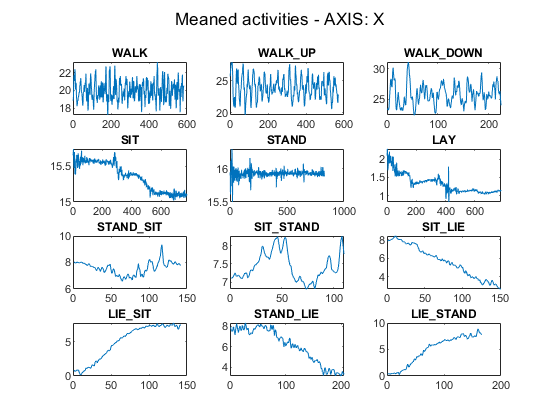

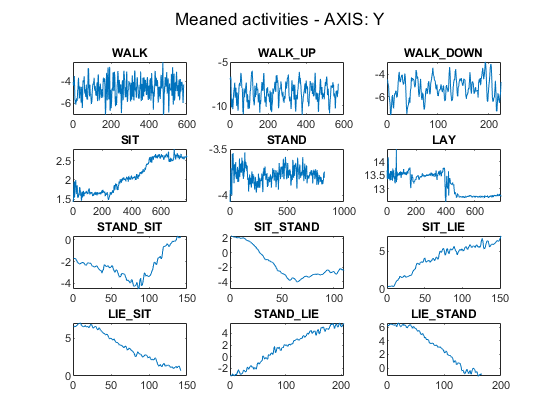

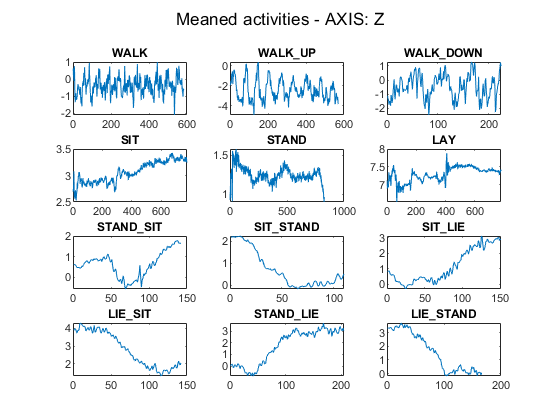

In [162]:
plot_meaned_activities(meaned_acts_x, X_AXIS, ACTIVITIES);
plot_meaned_activities(meaned_acts_y, Y_AXIS, ACTIVITIES);
plot_meaned_activities(meaned_acts_z, Z_AXIS, ACTIVITIES);

## 7. Seleção da janela deslizante

<div style="text-align: justify">
<br>
        &nbsp;&nbsp;&nbsp;&nbsp;Para a seleção da janela deslizante a aplicar nos pontos 11 e 12 deste relatório, foram efetuados testes sobre a atividade dinâmica <i> WALK </i>, uma vez que o seu sinal apresenta, no geral, uma elevada quantidade de mudanças bruscas na sua amplitude. Esta característica permite assim testar o comportamento das várias janelas (retangular, gaussiana, <i>Blackman</i>, <i>Hamming</i>, <i>Hann</i>).
</div>

In [141]:
%%file plot_window.m

function plot_window(win_func, win_size, win_name)
    win = win_func(win_size);
    
    figure;
    
    plot(1:win_size, win);
    title(win_name);
    xlabel('N')
    ylabel('W(N)');
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_window.m'.


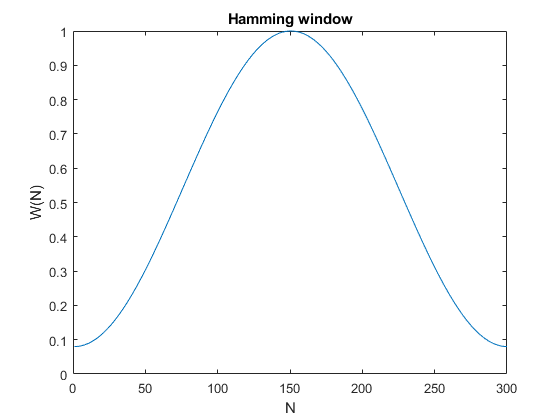

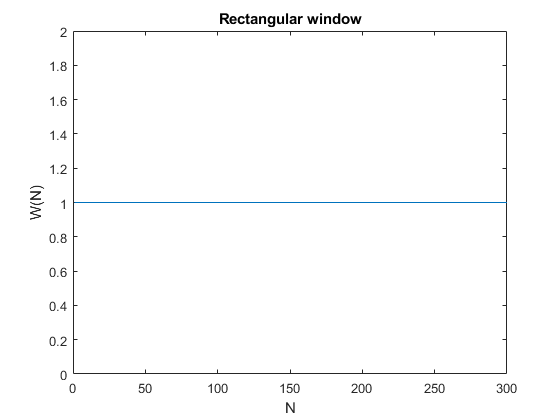

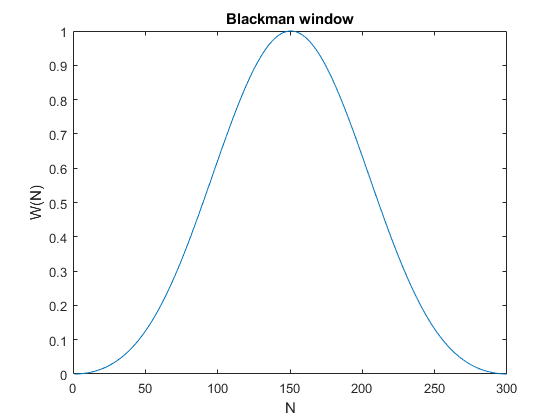

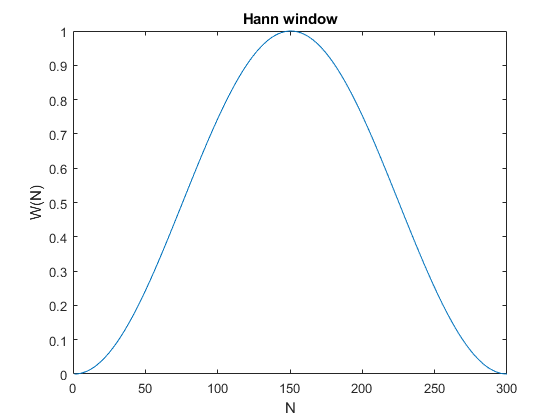

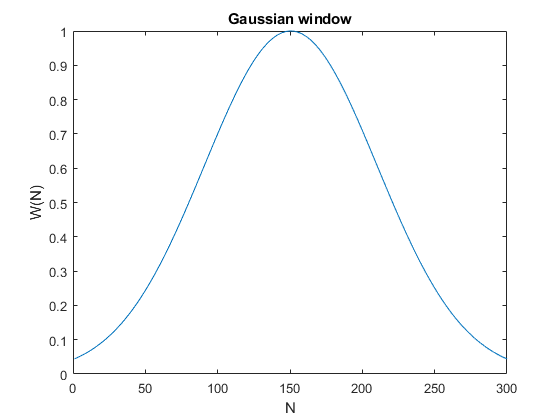

In [163]:
plot_window(@hamming, WINDOW_SIZE * FS, 'Hamming window');
plot_window(@rectwin, WINDOW_SIZE * FS, 'Rectangular window');
plot_window(@blackman, WINDOW_SIZE * FS, 'Blackman window');
plot_window(@hann, WINDOW_SIZE * FS, 'Hann window');
plot_window(@gausswin, WINDOW_SIZE * FS, 'Gaussian window');

In [174]:
%%file plot_windowed_dft.m

%{
@def plot_windowed_dft
@brief Function that plots a given windowed dft.

@param dataset
Dataset with the values obtained during the experiments.

@param interval
Time interval to consider.

@param win_func
Pointer to the function associated with type of window to plot.

@param title_str
Title to atribute to the plotted graphic.

@param i
Index to identify the position for the plotted graphic.

%}
function plot_windowed_dft(dataset, fs, interval, win_func, title_str, i)
    t_win = interval(end) - interval(1) + 1;
    n_win = round(t_win);
    window = win_func(n_win);
     
    % consider the three dimensions
    for k = 1:3
        subplot(5, 3, 3 * i + k);
        
        % apply the window to the dataset frame
        values = dataset(interval, k).*window;
        
        % calculate the dft for the frame
        [~, dft] = calc_dft(values, fs, 1, length(interval));
        
        plot(interval, dft);
        plotname = sprintf('DFT %s | AXIS: %s', title_str, get_axis_name(k));
        title(plotname);
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_windowed_dft.m'.


In [ ]:
plot_windowed_dft(datasets{1}, FS, 7496:8078, @hamming, ' | Hamming window - Act. W, Inst. 1, Exp. 1', 0);
plot_windowed_dft(datasets{1}, FS, 7496:8078, @rectwin, ' | Rectangular window - Act. W, Inst. 1, Exp. 1', 1);
plot_windowed_dft(datasets{1}, FS, 7496:8078, @blackman, ' | Blackman window - Act. W, Inst. 1, Exp. 1', 2);
plot_windowed_dft(datasets{1}, FS, 7496:8078, @hann, ' | Hann window - Act. W, Inst. 1, Exp. 1', 3);
plot_windowed_dft(datasets{1}, FS, 7496:8078, @gausswin, ' | Gaussian window - Act. W, Inst. 1, Exp. 1', 4);

![Title](resources/plots/windowed_dft.png)

## 8. DFT dos sinais associados às atividades

In [142]:
%%file plot_meaned_dfts.m

function plot_meaned_dfts(freqs, meaned_dfts, num_ocurrences, activities, axis)
    for i = 1:length(activities)
        plot(cell2mat(freqs(i)), cell2mat(meaned_dfts(i)));
        plt_title = sprintf('DFT mean for activity %s (%d instances in all datasets) - AXIS %s', activities(i), num_ocurrences(i), get_axis_name(axis));
        title(plt_title);
        xlabel('Frequency (Hz)');
        ylabel('Magnitude');
        pause(1);
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_meaned_dfts.m'.


In [ ]:
plot_meaned_dfts(freqs_x, dfts_x, num_act_ocurrences, ACTIVITIES, X_AXIS);
plot_meaned_dfts(freqs_y, dfts_y, num_act_ocurrences, ACTIVITIES, Y_AXIS);
plot_meaned_dfts(freqs_z, dfts_z, num_act_ocurrences, ACTIVITIES, Z_AXIS);

![Title](resources/plots/dfts/dft_x.png)
![Title](resources/plots/dfts/dft_y.png)
![Title](resources/plots/dfts/dft_z.png)

## 9. Estimativa do número de passos por minuto por utilizador

<div style="text-align: justify">
<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Para estimar o número de passos por minuto (<i>NPM</i>) de utilizador adotou-se uma metodologia semelhante à descrita em <i> https://www.aosabook.org/en/500L/a-pedometer-in-the-real-world.html</i>: assumindo que os sinais associados às atividades dinâmicas (<i>WALKING</i>, <i>WALKING_UP</i> e <i>WALKING_DOWN</i>) são sinais aproximadamente periódicos e oscilatórios, pode deduzir-se que um passo humano corresponde a uma oscilação. No entanto, o cálculo do <i>NPM</i> não é tão trivial como aparenta. É necessário isolar a componente da aceleração gravítica (nos três eixos), que é contabilizada nas medições efetuadas pelos acelerómetros e da componente da aceleração induzida pelo próprio utilizador. A primeira componente é obtida através da aplicação de um filtro <strong>passa baixo</strong> sobre os dados, com uma frequência máxima de 0.2<i>Hz</i>*; a segunda componente é obtida a partir da substração da primeira à aceleração total ($\vec{a_t} = \vec{a_g} + \vec{a_u}$). Atendendo ao facto de a locomoção do indivíduo não ser ideal, pois este oscila em várias direções, é crucial calcular a componente vertical da sua aceleração em função das restantes. Para tal, efetua-se o produto escalar entre a componente da aceleração gravítica e a componente da aceleração do utilizador, passando-se do espaço tridimensional para o espaço unidimensional.
<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Finalmente, é aplicada a $DFT$ em conjunto com a função <strong>findpeaks</strong> (<i>threshold</i> escolhida de 30%)  de modo a obter-se o conjunto de frequências mais relevantes associadas ao movimento do utilizador na direção vertical, considerando-se a primeira a utilizada para calcular o <i>NPM</i> (esta última escolha ficou ao critério do grupo, sendo, no entanto, necessário ser-se consistente ao longo das várias estimativas).
<br><br>
    <small style="font-size: 12px"> * idealmente a frequência associada à aceleração gravítica seria nula, mas visto que os acelerómetros não são ideais, é dada uma margem de erro de 0.2<i>Hz</i></small>
</div>

In [147]:
%%file calc_steps_per_min.m

%{
@def steps_per_min
@brief Function that calculates steps per minute per instance of activity.

@param data
Data used on the calculation.

@param min_freq
Minimal frequency to consider when applying a low-pass filter.

@param fs
Sample frequency used when capturing the data values.

@param thres_ref
Threshold reference to consider when discarding lower frequencies.

@return steps_per_min - number of steps per minutes calculated.
%}
function steps_per_min = calc_steps_per_min(data, min_freq, fs, thres_ref)
    
    % obtain the number of data entries and the number of components
    % considered
    N = size(data, 1);
    num_of_dim = size(data, 2);
    
    % prepare matrices for the gravitational acceleration and for the user
    % acceleration
    grav_ac = zeros(num_of_dim, N);
    user_ac = zeros(num_of_dim, N);
    
    % calculate user acceleration by removing gravitational acceleration
    % from total acceleration measured by the accelerometer on all of the
    % dimensions
    for i=1:num_of_dim
        grav_ac(i,:) = lowpass(data(:, i), min_freq, fs);
        user_ac(i, :) = data(:, i)'- grav_ac(i, :);
    end
    % calculate vertical acceleration
    vert_ac = dot(grav_ac, user_ac);
    
    [freqs, dft] = calc_dft(vert_ac, fs, 1, N);
    
    % remove non-positive values to discard duplicate values
    dft = dft(freqs > 0);
    freqs = freqs(freqs > 0);
    
    % define a threshold to discard lower step values and consider the first
    % relevant value to be the number of steps per minute
    threshold = max(dft) * thres_ref;
    [~, peaks_indexes] = findpeaks(dft, 'MinPeakHeight', threshold);
    peak_index = peaks_indexes(1);
    steps_per_min = freqs(peak_index) * 60;    
end  

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\calc_steps_per_min.m'.


In [148]:
%%file calc_act_steps_per_min.m

%{
@def calc_act_steps_per_min
@brief Function that calculates steps per minute for an activity.

@param data
Data describing the activity in the three dimensions (x, y, z).

@param min_freq
Minimal frequency to consider when applying a low-pass filter to the data.

@param fs
Sample frequency used when capturing the data values.

@param thres_ref
Threshold reference to consider when discarding lower frequencies.

@return mean_value - average number of steps per minutes calculated.
        std_value - standard deviation obtained.
%}

function [mean_value, std_value] = calc_act_steps_per_min(data, min_freq, fs, thres_ref)
    N = length(data);
    
    values = [];
    for i=1:N
        data_x = data{i}(:, 1);
        data_y = data{i}(:, 2);
        data_z = data{i}(:, 3);
        values = [values, calc_steps_per_min([data_x, data_y, data_z], freq, fs, thres_ref)];
    end
    mean_value = mean(values);
    std_value = std(values);
    
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\calc_act_steps_per_min.m'.


In [149]:
%%file calc_users_steps_per_min

%{
@def calc_steps_users
@brief Function that calculates the average steps per minute and correspondent
      standard deviation in all of the dynamic activies for the first N users.

@param datasets
Datasets describing the experiences performed by the users.

@param fs
Sample frequency used when capturing the data values.

@param min_freq
Minimal frequency to consider when applying a low-pass filter to the data.

@param thres_ref
Threshold reference to consider when discarding lower frequencies.

@param num_users
Number of users to consider.

@param dynamic_acts
Vector with the indexes associated with the dynamics activities considered.

@param labels
Vector with labels describing the experiences performed by the users.

@return steps_table - table containing the values obtained.
%}

function steps_table = calc_users_steps_per_min(datasets, fs, min_freq, thres_ref, num_users, dynamic_acts, labels) 
    
    users = 1:1:num_users;
    
    % create arrays to store the data;
    walk_avgs = [];
    walk_stds = [];
    walk_up_avgs = [];
    walk_up_stds = [];
    walk_down_avgs = [];
    walk_down_stds = [];
    
    for i=1:num_users
        user_acts = group_activities(datasets, i, labels, dynamic_acts);
        
        %calculate the average steps per minute and standard deviation for
        %the WALK activity
        walk_data = user_acts{1};
        [mean_value, std_value] = calc_act_steps_per_min(walk_data, min_freq, fs, thres_ref);
        
        walk_avgs = [walk_avgs, mean_value];
        walk_stds = [walk_stds, std_value];
        
        %calculate the average steps per minute and standard deviation for
        %the WALK_UP activity
        walk_up_data = user_acts{2};
        [mean_value, std_value] = calc_act_steps_per_min(walk_up_data, min_freq, fs, thres_ref);
        
        walk_up_avgs = [walk_up_avgs, mean_value];
        walk_up_stds = [walk_up_stds, std_value];
        
        %calculate the average steps per minute and standard deviation for
        %the WALK_DOWN activity
        walk_down_data = user_acts{3};
        [mean_value, std_value] = calc_act_steps_per_min(walk_down_data, min_freq, fs, thres_ref);
        
        walk_down_avgs = [walk_down_avgs, mean_value];
        walk_down_stds= [walk_down_stds, std_value];
        
    end
    
    USER = users';
    WALK_MEAN = walk_avgs';
    WALK_STD = walk_stds';
    WALK_UP_MEAN = walk_up_avgs';
    WALK_UP_STD = walk_up_stds';
    WALK_DOWN_MEAN = walk_down_avgs';
    WALK_DOWN_STD = walk_down_stds';
    
    steps_table = table(USER, WALK_MEAN, WALK_STD, WALK_UP_MEAN, WALK_UP_STD, WALK_DOWN_MEAN, WALK_DOWN_STD);
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\calc_users_steps_per_min'.


In [150]:
disp(calc_users_steps_per_min(datasets, FS, LOW_PASS_MIN_FREQ, THRESHOLD2, 4, DYNAMIC_ACTIVITIES, labels));

    USER    WALK_MEAN    WALK_STD    WALK_UP_MEAN    WALK_UP_STD    WALK_DOWN_MEAN    WALK_DOWN_STD
    ____    _________    ________    ____________    ___________    ______________    _____________

     1       105.09       3.7368        91.378         2.5942           105.14            5.323    
     2        107.2       3.2547        96.103         5.1067            102.1           8.4376    
     3       100.67        2.877        88.746         5.5383           95.296           16.193    
     4       116.06       3.2013        94.242         9.5401           97.057           13.896    




## 10. Distinção das famílias e tipos de atividades

<div style="text-align: justify">
<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Tal como demonstrado no ponto 6, é possível distinguir as três famílias de atividades, não só recorrendo aos conhecimentos de análise e transformação de dados, mas também recorrendo a conceitos básicos de análise matemática, como o <strong>declive</strong>. É possível distinguir então, as atividades <strong>estáticas</strong> e <strong>dinâmicas</strong> das atividades de <strong>transição</strong>, visto que as primeiras apresentam um declive muito inferior relativamente ao declive das segundas, como demonstrado abaixo graficamente. No entanto, não é possível distinguir as atividades <strong>estáticas</strong> das <strong>dinâmicas</strong> recorrendo a este método, dado que apresentam declives muito semelhantes. Como solução para este problema, é calculado o valor máximo da $DFT$ das atividades das famílias referidas, visto que ambas apresentam amplitudes distintas. Verifica-se que as atividades <strong>dinâmicas</strong> possuem valores máximos da $DFT$ muito superiores comparativamente aos obtidos para as atividades <strong>estáticas</strong>. É importante salientar que estes dois critérios foram utilizados no último ponto deste relatório.
</div>

In [ ]:
%%file plot_dataset_param.m

function plot_dataset_param(meaned_acts, act_names, param_func, param_name, axis, colors, dx, dy)  
    figure;
    
    hold on;
    
    for i = 1:length(meaned_acts)
         values = cell2mat(meaned_acts(i));
         domain = 1:length(values);
         
         param_value = param_func(domain, values);
         scatter(i, param_value, 'MarkerFaceColor', colors{i}, 'MarkerEdgeColor', 'black');
         point_lbl = sprintf('%.5f', param_value);
         ylbl = sprintf('Comparison param (%s)', param_name);
         text(i + dx, param_value + dy * (-1)^i, point_lbl, 'Fontsize', 8);
         xlabel('Activity index');
         ylabel(ylbl);
    end
    
    legend(act_names(:), 'Location', 'northwest');
    plt_title = sprintf('%s param comparison - AXIS: %s', param_name, get_axis_name(axis));
    title(plt_title);
    
    hold off;
end

In [ ]:
plot_dataset_param(meaned_acts_x, ACTIVITIES, @get_abs_slope, ABS_SLOPE_PARAM, X_AXIS, COLORS, 0.0025, 0.0015);
plot_dataset_param(meaned_acts_y, ACTIVITIES, @get_abs_slope, ABS_SLOPE_PARAM, Y_AXIS, COLORS, 0.0025, 0.0015);
plot_dataset_param(meaned_acts_z, ACTIVITIES, @get_abs_slope, ABS_SLOPE_PARAM, Z_AXIS,COLORS, 0.0025, 0.0015);
plot_dataset_param(meaned_acts_x, ACTIVITIES, @get_max_amplitude, MAX_FREQ, X_AXIS, COLORS, 0.003, 0.03);
plot_dataset_param(meaned_acts_y, ACTIVITIES, @get_max_amplitude, MAX_FREQ, Y_AXIS, COLORS, 0.003, 0.03);
plot_dataset_param(meaned_acts_z, ACTIVITIES, @get_max_amplitude, MAX_FREQ, Z_AXIS, COLORS, 0.003, 0.03);

![Title](resources/plots/param_comparisons/abs_slope_x.png)
![Title](resources/plots/param_comparisons/abs_slope_y.png)
![Title](resources/plots/param_comparisons/abs_slope_z.png)

![Title](resources/plots/param_comparisons/max_freq_amp_x.png)
![Title](resources/plots/param_comparisons/max_freq_amp_y.png)
![Title](resources/plots/param_comparisons/max_freq_amp_z.png)

<div style="text-align: justify">
<br>
    &nbsp;&nbsp;&nbsp;&nbsp; Com o segundo critério supracitado, já é possível fazer uma discriminação razoável entre os vários tipos de atividade (considerando o tipo de atividade uma categoria taxonómica abaixo da família de atividade). Porém, para se obter resultados mais exatos, foi também utilizada a $DFT$ com o intuito de se obterem as frequências mais relavantes com uma <i>threshold</i> de 25%.
</div>

![Title](resources/plots/relev_freqs/relev_freqs_x.png)
![Title](resources/plots/relev_freqs/relev_freqs_y.png)
![Title](resources/plots/relev_freqs/relev_freqs_z.png)

## 11. Aplicação da STFT aos datasets

<div style="text-align: justify">
<br>
    &nbsp;&nbsp;&nbsp;&nbsp; Para se obter informação dos <i>datasets</i> no domínio temporal e de frequências foi desenvolvida a função <strong>calc_stft</strong> que, tal como o nome indica, calcula a <i>Short Time Fourier Transform</i> dos dados. Inicialmente é computado o tamanho e a sobreposição das janelas, em amostras (<i>N</i>), tendo em conta a frequência de amostragem. De seguida é calculado o vetor de frequências correspondente ao sinal e a função de janela a considerar. Essa janela é então "deslizada" ao longo da sequência temporal e, através da aplicação $DFT$ nos segmentos resultantes, são obtidas as frequências mais relevantes dos mesmos. Foram efetuados vários testes cujas variáveis independentes eram o <strong>tamanho da janela</strong> e a <strong>sobreposição</strong> da mesma ao longo dos dados. De entre os testes realizados, verificou-se que se obtiveram resolução temporal e de frequência satisfatórias para um tamanho de janela de 8s e de sobreposição de 6s.
</div>

In [ ]:
%%file calc_stft.m

%{
@def calc_stft
@brief Function that calculates the STFT for a given dataset.

@param dataset
Dataset to use on STFT calculation.

@param fs
Sample frequency used when capturing the values on the dataset.

@param window_type
The type of window to apply to the dataset.

@param window_size
The size of each window to consider.

@param overlap_size
The size of overlaping to consider on the window application to the
dataset.

@return relev_freqs - vector with the relevant frequencies obtained.
        relev_mags -  vector with the magnitudes associated to each frequency obtained.
        times - vector with the time instances associated to each frequency
        obtained.
%}
function [relev_freqs, relev_mags, times] = calc_stft(x, fs, window_type, window_size, overlap_size)
    N = length(x);
    ts = 1/fs;
    
    % calculate the number of window frames and the number of overlapings
    n_frame = round(window_size * fs);
    n_overlap = round(overlap_size * fs);
    
    % obtain the frequencies vector
    if mod(n_frame, 2) == 0
        f_frame = -fs/2:fs/n_frame:fs/2-fs/n_frame;
    else
        f_frame = -fs/2 + fs/(2*n_frame):fs/n_frame:fs/2-fs/(2*n_frame);
    end
    
    % calculate the window
    window = window_type(n_frame);
    
    % prepare arrays to store the results
    relev_freqs = [];
    relev_mags = [];
    times = [];
    
    % obtain the time vector
    t = 0:ts:(N-1)*ts;
    
    for i = 1:n_frame-n_overlap:N-n_frame+1
        % obtain the frame to consider
        x_frame = x(i:i+n_frame-1);
        x_frame = dtrend(x_frame);
        
        % apply the window to the frame
        x_frame = x_frame.*window;
        
        % calculate the DFT of the frame
        X_frame = fftshift(fft(x_frame));
        
        % obtain the magnitudes
        m_X_frame = abs(X_frame);
        
        % obtain the maximum magnitude
        mag = max(m_X_frame);
        
        % obtain the relevant frequencies and the corresponding magnitutes
        % and time instances
        freqs = f_frame(abs(m_X_frame - mag) < 0.001);
        relev_freqs = [relev_freqs, abs(freqs(1))];
        relev_mags = [relev_mags, mag];
        times = [times, t(i)];
    end
        
end

In [183]:
%%file plot_stft.m

%{
@def plot_stft
@brief Function that calculates the STFTs from the datasets and plots the results.

@param dataset
Dataset to use on STFT calculation.

@param fs
Sample frequency used when capturing the values on the dataset.

@param window_type
The type of window to apply to the dataset.

@param window_size
The size of each window to consider.

@param overlap_size
The size of overlaping to consider on the window application to the
dataset.
%}
function plot_stft(dataset, fs, window_type, window_size, overlap_size)
    figure;   
    % plot the stft for in all of the three dimensions (x, y, z)
    for k = 1:3
        [relev_freqs, ~, times] = calc_stft(dataset(:,k), fs, window_type, window_size, overlap_size);
        subplot(3,1,k)
        plot(times/60, relev_freqs, 'o');
        plt_title = sprintf('AXIS: %s', get_axis_name(k));
        title(plt_title);
        xlabel('Time (min)');
        ylabel('Frequency (Hz)');
    end
    
    % plot the spectrogram for the stft for in all of the three dimensions (x, y, z)
    for k = 1:3
        figure;
        xlabel('Time (s)');
        spectrogram(dataset(:,k), window_size*fs, overlap_size*fs, 'yaxis');
        plt_title = sprintf('AXIS: %s', get_axis_name(k));
        title(plt_title);
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_stft.m'.


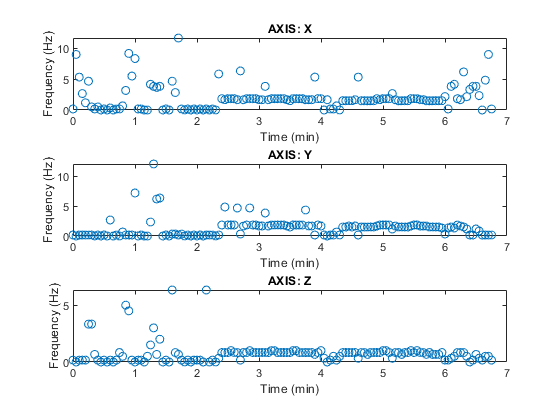

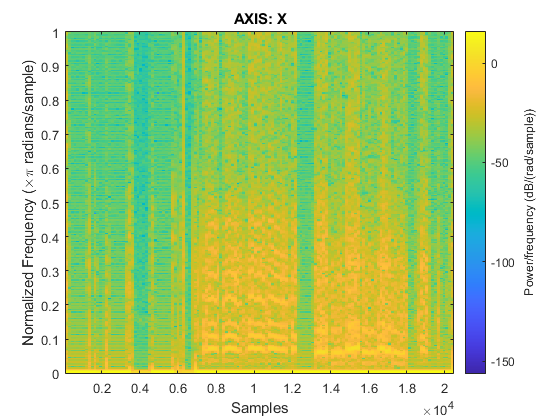

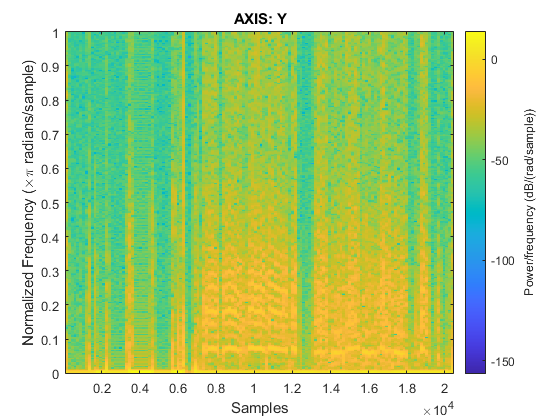

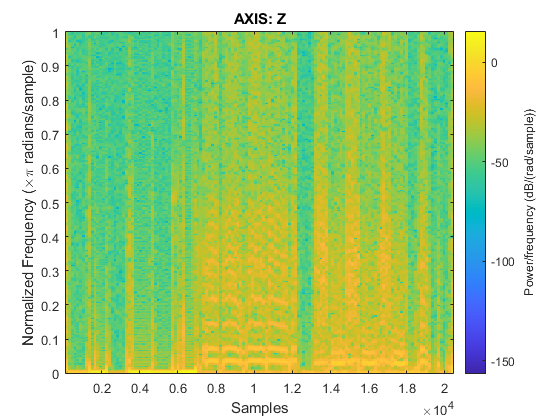

In [185]:
plot_stft(cell2mat(datasets(1)), FS, @hann, WINDOW_SIZE, OVERLAP_SIZE);

## 12. *Actionalizer* - Reconhecimento de atividades

<div style="text-align: justify">
<br>
    &nbsp;&nbsp;&nbsp;&nbsp; Em jeito de conclusão, refere-se que foi desenvolvida uma funcionalidade extra (visto que não era impreterível, tendo em conta o enunciado fornecido). Esta funcionalidade permite efetuar o reconhecimento dos vários tipos de atividades de uma dada sequência temporal (neste caso é uma das fornecidas no <i> HAPT dataset</i>), tendo por base os conhecimentos obtidos nos pontos anteriores deste projeto. O funcionamento <i>core</i> desta função, que intitulámos de <i>Actionalizer</i> aproxima-se muito daquilo que se considera uma função <strong>multiobjetivo</strong>, na medida em que pretende minimizar três parâmetros: a distância das <strong>magnitudes</strong> e das <strong>frequências mais relevantes</strong>relativamente às esperadas e a diferença entre o <strong>declive da tendência linear</strong> previsto e obtido. É importante dizer que a função descrita permite definir o peso de cada uma das variáveis na estimação do tipo de atividade.
</div>

In [158]:
%%file actionalizer.m

function actionalizer(dataset, fs, window_type, window_size, overlap_size, freqs, dfts, slopes, activities)
    mag_factor = 1;
    freq_factor = 1;
    slope_factor = 1;
    
    
    N = length(dataset(:, 1));
    ts = 1/fs;
    n_frame = round(window_size * fs);
    n_overlap = round(overlap_size * fs);
    
    if mod(n_frame, 2) == 0
        f_frame = -fs/2:fs/n_frame:fs/2-fs/n_frame;
    else
        f_frame = -fs/2 + fs/(2*n_frame):fs/n_frame:fs/2-fs/(2*n_frame);
    end
    
    % 12 -> number of activities
    default_freq = zeros(3, 12);
    default_mag = zeros(3, 12);
    default_slope = zeros(3, 12);
    
    for i = 1:12
        for k = 1:3
            default_freq(k, i) = max(freqs{k}{i});
            default_mag(k, i) = max(dfts{k}{i});
            default_slope(k, i) = max(slopes{k}{i});
        end
    end
    
    window = window_type(n_frame);
    
    t = 0:ts:(N-1)*ts;
    
    for i = 1:n_frame-n_overlap:N-n_frame+1
        interval = i:i+n_frame-1;
        
        x_frame_x = dataset(interval, 1);
        x_frame_y = dataset(interval, 2);
        x_frame_z = dataset(interval, 3);

        slope_x = get_abs_slope(interval, x_frame_x);
        slope_y = get_abs_slope(interval, x_frame_y);
        slope_z = get_abs_slope(interval, x_frame_z);

        x_frame_x = detrend(x_frame_x).*window;
        x_frame_y = detrend(x_frame_y).*window;
        x_frame_z = detrend(x_frame_z).*window;

        m_X_frame_x = abs(fftshift(fft(x_frame_x)));
        m_X_frame_y = abs(fftshift(fft(x_frame_y)));
        m_X_frame_z = abs(fftshift(fft(x_frame_z)));

        mag_x = max(m_X_frame_x);
        mag_y = max(m_X_frame_y);
        mag_z = max(m_X_frame_z);

        freqs_x = f_frame(abs(m_X_frame_x - mag_x) < 0.001);
        freqs_y = f_frame(abs(m_X_frame_y - mag_y) < 0.001);
        freqs_z = f_frame(abs(m_X_frame_z - mag_z) < 0.001);

        freq_x = abs(freqs_x(1));
        freq_y = abs(freqs_y(1));
        freq_z = abs(freqs_z(1));

        min_error = 10000;
        correct_activitie = 0;
        
        for j = 1:12
            slop_deviation = norm(slope_factor*[default_slope(1, j) - slope_x, default_slope(2, j) - slope_y, default_slope(3, j) - slope_z]);
            freq_deviation = norm(freq_factor*[default_freq(1, j) - freq_x, default_freq(2, j) - freq_y, default_freq(3, j) - freq_z]);
            mag_deviation = norm(mag_factor*[default_mag(1, j) - mag_x, default_mag(2, j) - mag_y, default_mag(3, j) - mag_z]);
            
            error = norm([slop_deviation, freq_deviation, mag_deviation]);
            if error < min_error
                min_error = error;
                correct_activitie = j;
            end
        end
        
        %fprintf('Time %.1f(s): Slope (%.5f, %.5f, %.5f) Freq(%.5f, %.5f, %.5f) Mag(%.5f %.5f %.5f)\n', t(i), slope_x, slope_y, slope_z, freq_x, freq_y, freq_z, mag_x, mag_y, mag_z);
        fprintf('Time (%.1fs) [Interval: %d] GUESS: %s (%d) with an error of: %.5f\n', t(i), t(i)*fs, activities(correct_activitie), correct_activitie, min_error);
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\actionalizer.m'.
